# Meter Tracking in Carnatic Music

## Project Description
In this project, we are trying to track the beats in Carnatic music using a deep learning based on Long Short-Term Memory (LSTM) networks. The idea is to use raw T-F feautres from audio data and from this get instances where a beat should occur using LSTM network. 

## Dataset Details
Ajay's hand labeled dataset - CMR_dataset_full. The dataset contains:
1. 176 audio files
2. Beat-level annotations "1-8" with their time stamp in seconds for each of the audio files
3. Meter-level annotations (not used currently)

### Data Partitioning
The Entire audio data is divided into:
1. Training Data
2. Train-Dev Data: Same distribution as Training Data, but not used in Training.
3. Dev Data: Part of the data has same distribution as training and a part has different distribution. 
4. Test Data: Same as Dev data.

The way I partition the data is as follows:
1. The entire data is first divided into two sets - Set-1: 167 files, Set-2: 9 files
2. Training, Train-Dev and a part of Dev and Test data are chosen from Set -1 in the ratio:

    a) Training - 60%
    
    b) Train-Dev - 10%

    c) Dev - 15%

    d) Test - 15%
    
Note: The partitioning here is such that each partition has feature vectors from all 167 audio clips. 
3. Additionally the reamining part of the Dev and Test data are chosen from Set-2 in the ratio:
    
    a) Dev - 15%
    b) Test - 15%
    c) Train - 70% (Note this is part of the data is currently not used....for future if we observe that the model is not generalizing well to Dev data, this can be used)
    
This kind of partitioning ensures, Training and Train-Dev data have the same distribution. A part of Dev and Test Data have the same distribution as Training Data and the rest have a different distribution.
    
## Input features
1. Auditory spectrogram features - 128 dimensional features obtained from a mammalian auditory model.
2. Window length = 100ms (I had a feeling that for Music window length must be bigger than speech. Starting out with this big window...)
3. Window Shift = 100ms. (In auditory spectrogram, typically non-overalpping features are used.)


## Network Architecture

A crude idea is to use a bi-directional LSTM network for classifying each frame of input data into two classes - "Beat" vs "No Beat". Trying initially with 3 layers each for forward and backward layers with 25 units each. 
1. Input - 128 dimensional
2. Output (Softmax/Logistic) - 2 dimensional (One-Hot encoding) 
3. Number of hidden Layers = 3 (forward) + 3(backward)


## Notations and Convention
1. Number of examples - m
2. Input Dimensions - n_input
3. Number of time steps for TBPTT for training LSTMs = n_steps
4. Number of output classes - n_classes
5. Number of LSTMs per layer - num_hidden
6. Number of hidden Layers - number_of_layers

## Code Pipeline
1. Feature Processing + Partitioning - MATLAB (../MatlabScripts/DataPrep.m): This gives out 4 .mat files in the "../Data/" folder:

    a) Train.mat - Training data of size 128 X m_train
    
    b) Train-Dev.mat - Train-dev data of size 128 X m_train_dev
    
    c) Dev.mat - Dev data of size 128 X m_dev
    
    d) Test.mat - Test data of size 128 X m_test
This code expects audio data in: "../Database/CMR_dataset_full/audio/" and beat annotations in "../Database/CMR_dataset_full/annotations/beats/".
    
2. The LSTM implementation is in this IPython notebook using Tensorflow.

## LSTM Implementation

In [1]:
#Import the required packages
import numpy as np
import math
import h5py
import scipy.io as sio
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print tf.__version__

1.3.0


In [5]:
# Define all the required Functions
def mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if No-beat, 1 beat), of shape (2, number of examples - one-hot encoding)
    mini_batch_size - size of the mini-batches, integer
    seed -- to reproduce results later...
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    n_input, m = X.shape                  # number of examples
    n_output = Y.shape[0]
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    batch_X = np.zeros((num_complete_minibatches,mini_batch_size, n_input))
    batch_Y = np.zeros((num_complete_minibatches,mini_batch_size, n_output))
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        batch_X[k,:,:] = mini_batch_X.T
        batch_Y[k,:,:] = mini_batch_Y.T
   
    #Shuffle the batches before you send it across
    permutation = list(np.random.permutation(num_complete_minibatches))
    shuffled_batch_X = batch_X[permutation,:,:]
    shuffled_batch_Y = batch_Y[permutation,:,:]

    return shuffled_batch_X, shuffled_batch_Y
    
def read_from_h5py_mat(dataset_type):
    # Inputs: dataset_type - Name of the Partition. Should be one of:
    # "Train", "Train-Dev", "Dev", or "Test"
    
    fname = "../Data/" + dataset_type + ".mat"
    varname = dataset_type.replace('-','_').lower()
    f = h5py.File(fname, 'r')
    data_X = np.array(f.get(varname +"_X")).T
    data_Y = np.array(f.get(varname +"_Y")).T
    #print data_Y.shape
    return data_X, data_Y
    
def load_music_dataset(mini_batch_size):
    
    
    train_X, train_Y = read_from_h5py_mat("Train")
    train_dev_X, train_dev_Y = read_from_h5py_mat("Train-Dev")
    dev_X, dev_Y = read_from_h5py_mat("Dev")
    test_X, test_Y = read_from_h5py_mat("Test")
    
    
    #Try taking the difference of successive frames to get better features for beat detection
#    train_X = np.diff(train_X, axis=1)
#    train_Y = np.diff(train_Y, axis=1)
#    
#    train_dev_X = np.diff(train_dev_X, axis=1)
#    train_dev_Y = np.diff(train_dev_Y, axis=1)
#    
#    dev_X = np.diff(dev_X, axis=1)
#    dev_Y = np.diff(dev_Y, axis=1)
#    
#    test_X = np.diff(test_X, axis=1)
#    test_Y = np.diff(test_Y, axis=1)
    
#    # Normalize Data to have zero mean and unit variance along all dimensions    
#    mean_vec = np.mean(train_X, axis=1, keepdims=True)
#    train_X = train_X - mean_vec
#    std_vec = np.std(train_X, axis=1, keepdims=True)
#    print std_vec
#    train_X /= std_vec
#    train_Y = np.reshape(train_Y[1,:],(1,-1))
    #Reshape data in train_X to fit Tensorflow RNN cell requirement to be of 
    #size - (batch_size, n_steps, n_input)
    #
    train_X, train_Y = mini_batches(train_X, train_Y, mini_batch_size)

    #Apply Training normalization to Train-Dev dataset
#    train_dev_X = train_dev_X - mean_vec
#    train_dev_X /= std_vec
#    train_dev_Y = np.reshape(train_dev_Y[1,:],(1,-1))
    #Reshape data for Tensorflow and divide into batches
    train_dev_X, train_dev_Y = mini_batches(train_dev_X, train_dev_Y, mini_batch_size)

    #Apply Training normalization to Dev dataset
#    dev_X = dev_X - mean_vec
#    dev_X /= std_vec
#    dev_Y = np.reshape(dev_Y[1,:],(1,-1))
    #Reshape data for Tensorflow and divide into batches
    dev_X, dev_Y = mini_batches(dev_X, dev_Y, mini_batch_size)

    #Apply Training normalization to Dev dataset
#    test_X = test_X - mean_vec
#    test_X /= std_vec
#    test_Y = np.reshape(test_Y[1,:],(1,-1))
    #Reshape data for Tensorflow and divide into batches
    test_X, test_Y = mini_batches(test_X, test_Y, mini_batch_size)

    
    return train_X, train_Y, train_dev_X, train_dev_Y, dev_X, dev_Y, test_X, test_Y

def create_placeholders(n_input, n_classes, n_steps):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_input -- scalar, Dimension of the input features (here it is 128)
    n_classes -- scalar, number of output classes (=2, beat/no beat classification)
    n_steps -- scalar, The number time steps in of Truncated BackProp Through Time (TBPTT)
    
    Returns:
    X -- placeholder for the data input, of shape [n_input, n_steps, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_classes, n_steps, None] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=(None, n_steps, n_input))
    Y = tf.placeholder(tf.float32, shape=(None, n_steps, n_classes))
    
    
    return X, Y

def initialize_parameters(num_hidden, n_classes):
    """
    Initializes parameters of the LSTM network. The shapes are:
                        
    Input: 
    num_hidden -- scalar, indicates the number of LSTMS in the final hidden layer
    n_classes -- scalar, number of output classes (=2)
    
    Returns:
    parameters -- a dictionary of tensors containing W-out b-out, Weights and bias for the Softmax layer.
    Note: The other weights are implicitly taken care of by Tensorflow.
    """
    
    #Initialize the Weights and Biases of the final Softmax Layer

    parameters = {}
    parameters["W-out"] = tf.get_variable("W-out", shape=[2*num_hidden, n_classes], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    parameters["b-out"] = tf.get_variable("b-out", shape=[n_classes], initializer=tf.constant_initializer(0.0))
    
    #Note: I am multiplying 2 to num_hidden in parameters["W-out"], because this will be a bi-directional LSTM
    #with num_hidden units for forward LSTM layer and num_hidden units for backward LSTM layer.
    
    return parameters
    
def RNN(x, parameters, n_steps, num_hidden, number_of_layers, n_classes):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (num_batches, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (num_batches, n_input)
    #n_steps = x.shape[1]
    # Permuting num_batches and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*num_batches, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (num_batches, n_input)
    x = tf.split(x, n_steps, axis=0)
    
    
    # Define a lstm cell with tensorflow
    ########NOTE to Self: Re-Check stat_is_tuple and confirm concretely
    
    stacked_lstm_fw=[]
    stacked_lstm_bw=[]
    for layer_id in range(number_of_layers):
        stacked_lstm_fw.append(rnn.LSTMCell(num_hidden, state_is_tuple=True))
        stacked_lstm_bw.append(rnn.LSTMCell(num_hidden, state_is_tuple=True))
    multi_fw = rnn.MultiRNNCell(stacked_lstm_fw, state_is_tuple=True)
    multi_bw = rnn.MultiRNNCell(stacked_lstm_bw, state_is_tuple=True)

    outputs,_,_  = rnn.static_bidirectional_rnn(multi_fw, multi_bw, x, dtype=tf.float32)

    # Get lstm cell output
    #outputs - n_steps X num_batches X n_input
    #Permuting the first and second dimensions - num_batches X n_steps X n_input
    op2 = tf.transpose(outputs,[1,0,2])
    # Reshaping to 2D tensor for multiplication (num_batches*n_steps) X num_hidden
    op3 = tf.reshape(op2,[-1,2*num_hidden])
    
    #Return the logits of shape num_batches X n_steps X n_classes
    logits = tf.reshape(tf.matmul(op3, parameters["W-out"]) + parameters["b-out"],[-1,n_steps,n_classes])
    
    return logits

def compute_cost(logits,Y):
    
    #Both logits and Y are of shape num_batches X n_steps X n_classes. So, convert them to be 
    # of shape (batch_size X n_steps) X n_classes
    logits = tf.reshape(logits, [-1, n_classes])
    labels = tf.reshape(Y, [-1, n_classes])
    #weights = tf.reshape(tf.constant([0.1,0.9]),[1,2])
    #logits = logits*weights
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits\
                        (logits=logits, targets=labels,pos_weight=0.010))
    
    return cost
    
def model(train_X, train_Y, train_dev_X, train_dev_Y, dev_X, dev_Y, test_X, test_Y,\
          num_hidden, num_layers, learning_rate = 0.0001, num_epochs = 1500, \
          minibatch_size = 32, print_cost = True):
    """
    Implements a Multi-layer tensorflow LSTM Recurrent neural network: 
        LSTM * num_layers ->SOFTMAX.
    
    Arguments:
    train_X -- training set, of shape (input size = 128, number of training examples = ?)
    train_Y -- training labels, of shape (output size = 1, number of training examples = ?)
    train_dev_X -- train-dev set, of shape (input size = 128, number of examples = ?)
    train_dev_Y -- train-dev labels, of shape (output size = 1, number of examples = ?)
    dev_X -- dev set, of shape (input size = 128, number of examples = ?)
    dev_Y -- dev labels, of shape (output size = 1, number of examples = ?)
    test_X -- test set, of shape (input size = 128, number of examples = ?)
    test_Y -- test labels, of shape (output size = 1, number of examples = ?)
    num_layers -- Number of LSTM layers
    num_hidden -- Number of LSTM cells per layer
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch == Number of steps = n_steps == 
    Number of steps in a truncated back prop algo
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    tf.reset_default_graph()
    _, n_steps, n_input = train_X.shape
    n_classes = train_Y.shape[2]
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders for X and Y
    X, Y = create_placeholders(n_input, n_classes, n_steps)


    # Initialize parameters
    parameters = initialize_parameters(num_hidden, n_classes)

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    logits = RNN(X, parameters, n_steps, num_hidden, number_of_layers, n_classes)

    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(logits, Y)

    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

     # Calculate the correct predictions: Compute the average Hamming Score
#    nn_op =  
    logits = tf.reshape(logits,[-1, n_classes])
    labels = tf.reshape(Y,[-1, n_classes])
    pred = tf.nn.softmax(logits)
    #correct_prediction = tf.equal(tf.argmax(pred,axis=1), tf.argmax(labels,axis=1))
    #correct_prediction = tf.equal(pred >= 0.5, labels>0)

    # Calculate accuracy on the test set
    #accuracy = tf.reduce_mean(tf.reduce_mean(tf.cast(correct_prediction, "float"),axis=1))*100.0
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))*100.0
    #Do not use Accuracy use F-measure or F1 score
    _,prec = tf.metrics.precision(predictions=pred, labels=labels)
    _,recall = tf.metrics.recall(predictions=pred, labels=labels)
    accuracy = 2.0 * tf.multiply(prec,recall)/(tf.add(prec, recall))#Actually F-score but just called accuracy
#    accuracy,_ = tf.metrics.auc(predictions=pred, labels=labels)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        sess.run(tf.local_variables_initializer())
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            
            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            
            _ , batch_cost = sess.run([optimizer, cost], feed_dict={X: train_X, Y: train_Y})
            
            
            epoch_cost += batch_cost

            # Print the cost every epoch 
            if print_cost == True :
                #parameters = sess.run(parameters)
                train_acc = sess.run(accuracy, feed_dict={X: train_X, Y: train_Y})
                train_dev_acc = sess.run(accuracy, feed_dict={X: train_dev_X, Y: train_dev_Y})
                dev_acc = sess.run(accuracy, feed_dict={X: dev_X, Y: dev_Y})
                print ("%i\t %.5f\t %.2f\t %.2f\t %.2f\n " % (epoch, epoch_cost, train_acc, train_dev_acc, dev_acc))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        train_acc = sess.run(accuracy, feed_dict={X: train_X, Y: train_Y})
        train_dev_acc = sess.run(accuracy, feed_dict={X: train_dev_X, Y: train_dev_Y})
        dev_acc = sess.run(accuracy, feed_dict={X: dev_X, Y: dev_Y})
        test_acc = sess.run(accuracy, feed_dict={X: test_X, Y: test_Y})
        
        train_pred = pred.eval({X: train_X, Y: train_Y})
        train_dev_pred = pred.eval({X: train_dev_X, Y: train_dev_Y})
        dev_pred = pred.eval({X: dev_X, Y: dev_Y})
        test_pred = pred.eval({X: test_X, Y: test_Y})

        
        
        return parameters, costs, train_acc, train_dev_acc, dev_acc, test_acc,\
                                train_pred, train_dev_pred, dev_pred, test_pred


### Load the dataset
Note the different partitions will be of shape - num_batches X n_steps X n_input

In [3]:
n_steps = 100
train_X, train_Y, train_dev_X, train_dev_Y, dev_X, dev_Y, test_X, test_Y = load_music_dataset(n_steps)
print("Train Data shape = " + str(train_X.shape))
print("Train-Dev Data shape = " + str(train_dev_X.shape))
print("Dev Data shape = " + str(dev_X.shape))
print("Test Data shape = " + str(test_X.shape))
print("Train Labels shape = " + str(train_Y.shape))
print("Train-Dev Labels shape = " + str(train_dev_Y.shape))
print("Dev Labels shape = " + str(dev_Y.shape))
print("Test Labels shape = " + str(test_Y.shape))
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")

Train Data shape = (3390, 100, 128)
Train-Dev Data shape = (564, 100, 128)
Dev Data shape = (897, 100, 128)
Test Data shape = (896, 100, 128)
Train Labels shape = (3390, 100, 2)
Train-Dev Labels shape = (564, 100, 2)
Dev Labels shape = (897, 100, 2)
Test Labels shape = (896, 100, 2)
---------------------------------------------------------------
---------------------------------------------------------------


### Train the Network and Save the Results

Epoch	Epoch-Cost	Train-Acc	TrainDev-Acc	Dev-Acc
0	 0.62860	 0.18	 0.18	 0.18
 
1	 0.62615	 0.18	 0.18	 0.18
 
2	 0.62370	 0.18	 0.18	 0.18
 
3	 0.62126	 0.18	 0.18	 0.18
 
4	 0.61883	 0.18	 0.18	 0.18
 
5	 0.61639	 0.18	 0.18	 0.18
 
6	 0.61395	 0.18	 0.18	 0.18
 
7	 0.61152	 0.18	 0.18	 0.18
 
8	 0.60907	 0.18	 0.18	 0.18
 
9	 0.60662	 0.18	 0.18	 0.18
 


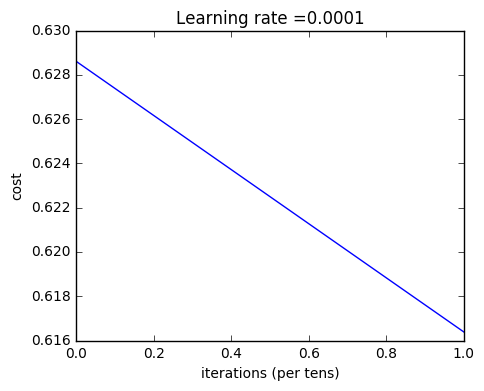

Parameters have been trained!


In [6]:
n_input = 128
num_hidden = 25
number_of_layers = 3
n_classes = 2
num_iter = 10
nn_config = "NumLayers_" + str(number_of_layers) + "num_iter_" + str(num_iter)

new_params_fname = '../Results/Parameters_NN_config_' + nn_config + ".mat"
print("Epoch\tEpoch-Cost\tTrain-Acc\tTrainDev-Acc\tDev-Acc")
parameters, costs, train_acc, train_dev_acc, dev_acc, test_acc,\
                    train_pred, train_dev_pred, dev_pred, test_pred =\
                 model(train_X, train_Y, train_dev_X, train_dev_Y, dev_X, dev_Y,\
                       test_X, test_Y,\
                       num_hidden= num_hidden,\
                       num_layers = number_of_layers,\
                       learning_rate = 0.0001, \
                       num_epochs = num_iter, \
                       minibatch_size = n_steps)

sio.savemat(new_params_fname,\
            {"parameters":parameters, 'costs':costs, 'train_acc': train_acc, \
            'train_dev_acc': train_dev_acc, 'dev_acc': dev_acc, 'test_acc': test_acc,\
            'train_pred':train_pred, 'train_dev_pred':train_dev_pred, 'dev_pred':dev_pred,\
            'test_pred':test_pred, 'train_Y':train_Y, 'train_dev_Y':train_dev_Y, 'dev_Y':dev_Y,\
            'test_Y':test_Y,})

## Some Comments:

1. Becuase of the huge data imbalance, the network is currently learning to only output zeros (mostly).
2. Weighted Cross-Entropy is somehow not heling much...
3. Need to figure out a way to train the network properly with data imbalance. I feel we can not emply data resampling techniques to either oversample the minority class or undersample the majority class

In [ ]:
print parameters["W-out"].shape


In [ ]:
plt.plot(costs)

In [ ]:
%matplotlib


In [ ]:
plt.plot(costs)